In [36]:
import torch
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import supervision as sv
from tqdm import tqdm 
import numpy as np
import pandas as pd 
from glob import glob
import subprocess
import gc 
import shutil

In [2]:
from diffusers import StableDiffusionPipeline
from diffusers import DiffusionPipeline, UNet2DConditionModel
from transformers import CLIPTextModel

/data/healthy-ml/scratch/qixuanj/anaconda3/envs/spurious_imagenet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
## Load final model 

# model_id = "/data/scratch/qixuanj/imagenet_runwayml_dreambooth_ckpts/runwayml_imagenet_class94_bird-feeder/"
# pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, use_safetensors=True)
# pipe = pipe.to("cuda")

In [3]:
checkpoint_prefix = "runwayml_imagenet_"
checkpoint_name = "class94_flower"
checkpoint_num = "2000"

In [61]:
checkpoints = glob("/data/scratch/qixuanj/imagenet_runwayml_dreambooth_ckpts/*")
checkpoints = sorted([x.rsplit("/", maxsplit=1)[1].split("imagenet_")[-1] for x in checkpoints])

In [62]:
checkpoints

['class0_fisherman',
 'class0_fishing-net',
 'class0_grass',
 'class0_lake-surface',
 'class2_ocean',
 'class2_shark',
 'class324_flower',
 'class325_flower',
 'class384_leaves',
 'class384_tree-trunk',
 'class434_baby',
 'class434_bath-towel',
 'class80_black-grouse',
 'class80_prairie',
 'class94_bird-feeder',
 'class94_branch',
 'class94_flower',
 'class94_hummingbird']

In [4]:
## Load from checkpoint
file_prefix = f"/data/scratch/qixuanj/imagenet_runwayml_dreambooth_ckpts/{checkpoint_prefix}{checkpoint_name}/checkpoint-{checkpoint_num}"

model_id = "runwayml/stable-diffusion-v1-5"
unet = UNet2DConditionModel.from_pretrained(f"{file_prefix}/unet")
# if you have trained with `--args.train_text_encoder` make sure to also load the text encoder
text_encoder = CLIPTextModel.from_pretrained(f"{file_prefix}/text_encoder")

pipe = DiffusionPipeline.from_pretrained(model_id, unet=unet, text_encoder=text_encoder, dtype=torch.float16)
pipe.to("cuda")

Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|██████████████████████████████████████████████| 7/7 [00:00<00:00, 16.47it/s]


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.23.0",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [16]:
num_images = 50
# Keep running model to remove black images from NSFW trigger 
images = pipe(prompt=f"a photo of <{checkpoint_name}>", 
              negative_prompt="",
              strength=0.9, guidance_scale=7.5, num_inference_steps=50, 
              num_images_per_prompt=num_images).images

max_tries = 15
prev_num_empty = 0
while max_tries > 0: 
    num_empty = 0
    for img in images: 
        if np.array(img).mean() == 0: 
            num_empty += 1
            images.remove(img)
    # Also break out of loop if keep generating same number of black images 
    if num_empty == prev_num_empty: 
        break 
    else: 
        prev_num_empty = num_empty

    # No missing images to generate 
    if num_empty == 0: 
        break
    images += pipe(prompt=f"a photo of <{checkpoint_name}>", 
              negative_prompt="",
              strength=0.9, guidance_scale=7.5, num_inference_steps=50, 
              num_images_per_prompt=num_empty).images
    max_tries -= 1
for img in images: 
    if np.array(img).mean() == 0: 
        num_empty += 1
        images.remove(img)
print(max_tries)
print(len(images))

100%|████████████████████████████████████████████████████████████████████████████| 50/50 [02:36<00:00,  3.13s/it]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|████████████████████████████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.14s/it]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|████████████████████████████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.05it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|████████████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.56it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try aga

10
45


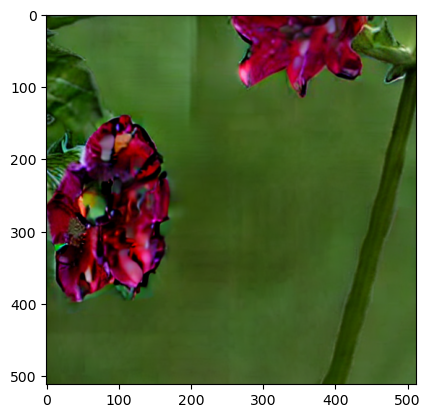

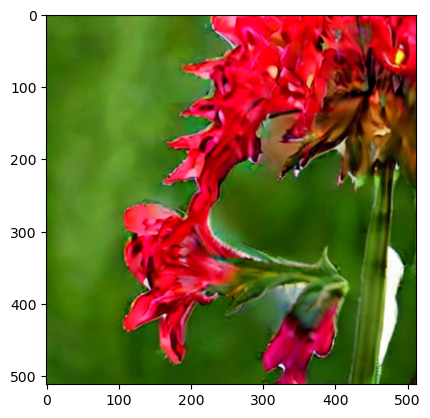

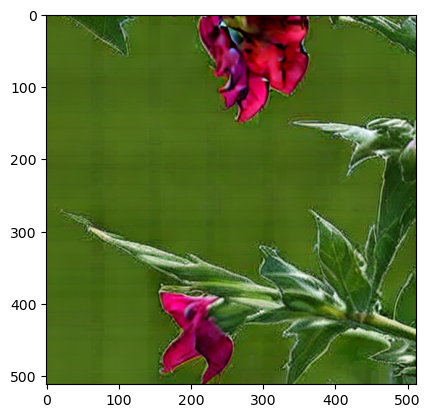

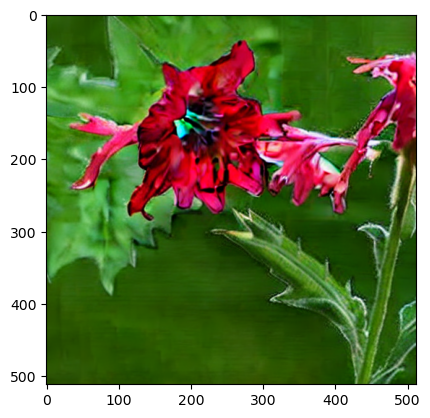

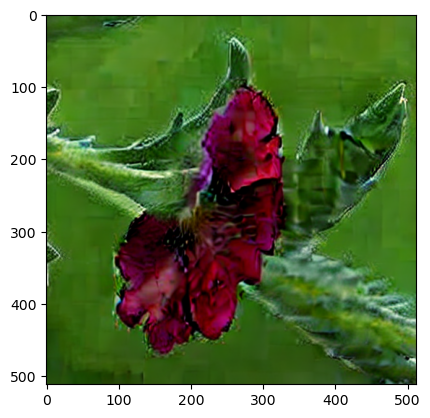

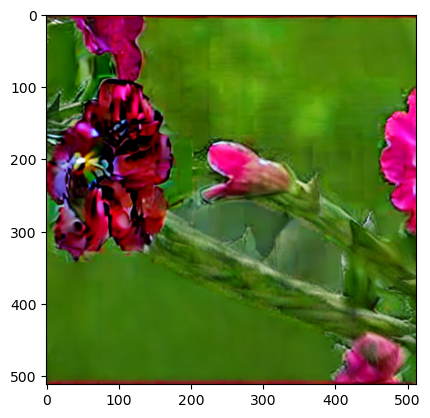

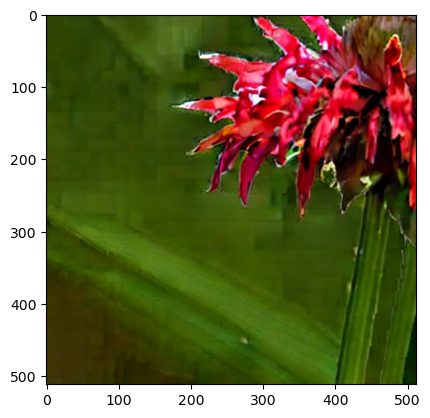

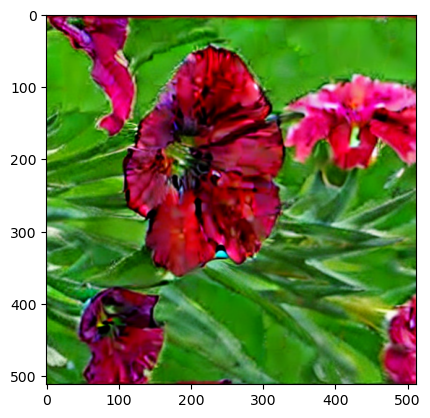

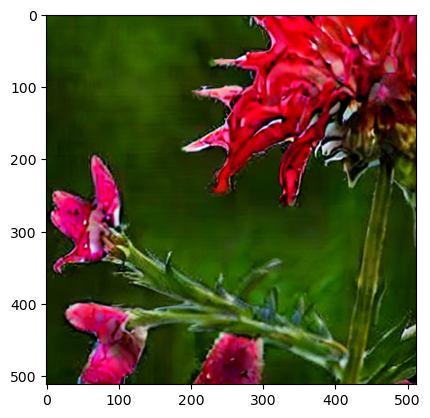

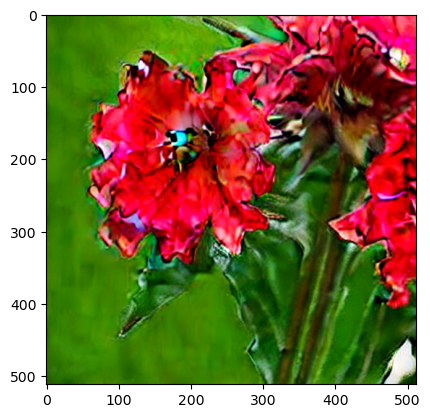

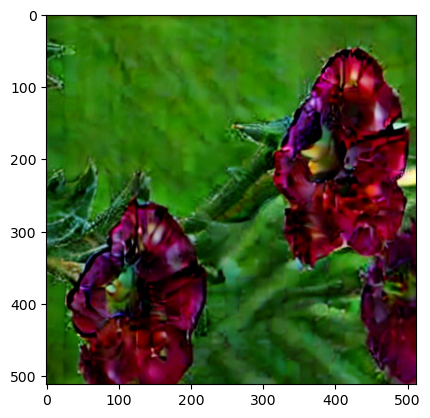

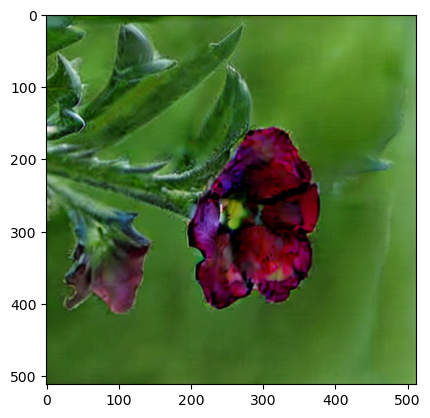

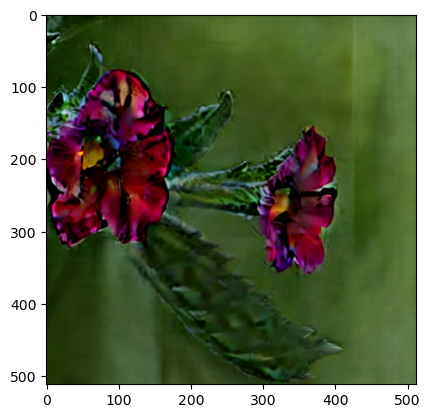

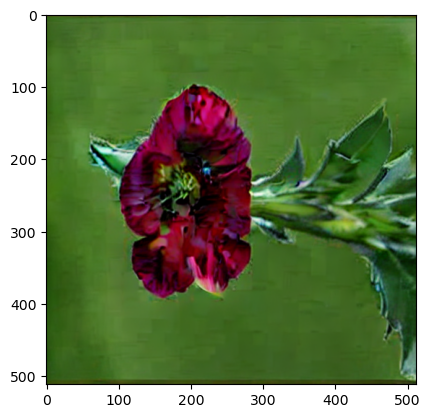

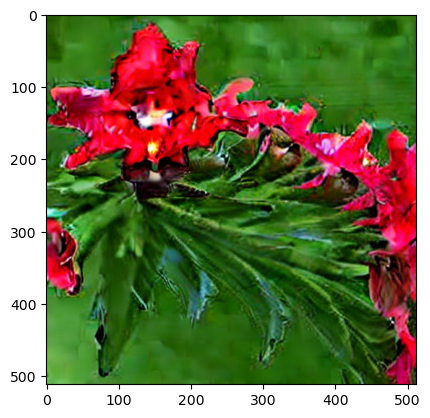

In [17]:
for img in images[:15]: 
    plt.imshow(img)
    plt.show()

In [18]:
# Save a couple of images to directory 
output_dir = f"imagenet_runwayml_dreambooth_imgs/{checkpoint_prefix}{checkpoint_name}/checkpoint-{checkpoint_num}" 
if not os.path.exists(output_dir): 
    os.makedirs(output_dir) 

In [19]:
seg_dir = output_dir + "-masked/"

In [20]:
for i, image in enumerate(images):
    image.save(output_dir + f"/image{i}.png")

# Remove Background

In [22]:
output_dir = os.getcwd() + "/" + output_dir
seg_dir = os.getcwd() + "/" + seg_dir 

In [79]:
program = f'''
source ~/.bashrc
conda activate spurious_imagenet
cd U2_Net
python u2net_test_copy.py --img_dir "{output_dir}" --prediction_dir "{seg_dir}"
'''

subprocess.call(program, shell=True, executable='/bin/bash',)

/bin/sh: 2: source: not found

CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.


Traceback (most recent call last):
  File "/data/healthy-ml/scratch/qixuanj/anaconda3/envs/spurious_imagenet/lib/python3.10/site-packages/tifffile/tifffile.py", line 907, in <module>
    import imagecodecs
ModuleNotFoundError: No module named 'imagecodecs'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/data/healthy-ml/scratch/qixuanj/generative_validation/U2_Net/u2net_test_copy.py", line 3, in <module>
    from skimage import io, transform
  File "<frozen importlib._bootstrap>", line 1075, in _handle_froml

KeyboardInterrupt: 

In [24]:
preprocess_dir = output_dir + "-preprocessed"
if not os.path.exists(preprocess_dir): 
    os.makedirs(preprocess_dir) 

In [26]:
img_paths = glob(output_dir + "/*.png", recursive = True)

In [28]:
# Code from https://stackoverflow.com/questions/50331463/convert-rgba-to-rgb-in-python 
def rgba2rgb( rgba, background=(0,0,0) ):
    row, col, ch = rgba.shape
    if ch == 3:
        return rgba
    assert ch == 4, 'RGBA image has 4 channels.'
    rgb = np.zeros( (row, col, 3), dtype='float32' )
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]

    a = np.asarray( a, dtype='float32' ) / 255.0

    R, G, B = background
    rgb[:,:,0] = r * a + (1.0 - a) * R
    rgb[:,:,1] = g * a + (1.0 - a) * G
    rgb[:,:,2] = b * a + (1.0 - a) * B

    return np.asarray( rgb, dtype='uint8' )

In [29]:
THRESHOLD = 0.8

for img_path in img_paths: 
    i = int(img_path.split(".png")[0].split("image")[-1])
    image = cv2.imread(img_path)
    mask_raw = cv2.imread(img_path.replace(f"checkpoint-{checkpoint_num}", 
                                           f"checkpoint-{checkpoint_num}-masked"))
    mask_raw = mask_raw / 255 
    mask_raw[mask_raw > THRESHOLD] = 1
    mask_raw[mask_raw <= THRESHOLD] = 0

    shape = mask_raw.shape
    a_layer_init = np.ones(shape = (shape[0],shape[1],1))
    mul_layer = np.expand_dims(mask_raw[:,:,0],axis=2)
    a_layer = mul_layer*a_layer_init
    rgba_out = np.append(mask_raw,a_layer,axis=2)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    a_layer = np.ones(shape = (shape[1],shape[0],1))
    rgba_inp = np.append(image,a_layer,axis=2)

    rem_back = 255*(rgba_inp*rgba_out)
    rem_back = rgba2rgb(rem_back)

    rem_back_scaled = Image.fromarray(rem_back.astype('uint8'), 'RGB')
    rem_back_scaled.save(preprocess_dir + f"/images{i}.png")
    
    # plt.imshow(rem_back_scaled)
    # plt.show()

# MIMIC-CXR Generation

In [ ]:
from diffusers import DiffusionPipeline, UNet2DConditionModel
from transformers import CLIPTextModel

In [ ]:
checkpoint_names = ["L-whole_L", "L-circle_L", "R-whole_R", "metal-leads_lead", "pacemaker_pacemaker", "portable-left_portable"]
checkpoint_nums = ["500", "1000", "1500", "2000", "2500"]

In [ ]:
dataset_name = "mimic-cxr"
for checkpoint_name in checkpoint_names: 
    feature_name = checkpoint_name.split("_")[0]
    for checkpoint_num in checkpoint_nums: 
        print(f"{checkpoint_name} with checkpoint {checkpoint_num}")
        file_prefix = f"/data/scratch/qixuanj/mimic-cxr_roentgen_dreambooth_ckpts/{checkpoint_name}/checkpoint-{checkpoint_num}"

        if not os.path.exists(file_prefix): 
            print("Model checkpoint does not exist!") 
            print(file_prefix)
            continue

        unet = UNet2DConditionModel.from_pretrained(f"{file_prefix}/unet")
        text_encoder = CLIPTextModel.from_pretrained(f"{file_prefix}/text_encoder")
        
        model_id = "/data/healthy-ml/scratch/qixuanj/generative_validation/roentgen" 
        pipe = DiffusionPipeline.from_pretrained(model_id, unet=unet, text_encoder=text_encoder, dtype=torch.float16)
        pipe.to("cuda")

        num_images = 50
        # Keep running model to remove black images from NSFW trigger 
        images = pipe(prompt=f"a photo of <{dataset_name}-{feature_name}>>", 
                      negative_prompt="",
                      strength=0.9, guidance_scale=7.5, num_inference_steps=50, 
                      num_images_per_prompt=num_images).images
        
        max_tries = 15
        prev_num_empty = 0
        while max_tries > 0: 
            num_empty = 0
            for img in images: 
                if np.array(img).mean() == 0: 
                    num_empty += 1
                    images.remove(img)
            # Also break out of loop if keep generating same number of black images 
            if num_empty == prev_num_empty: 
                break 
            else: 
                prev_num_empty = num_empty
        
            # No missing images to generate 
            if num_empty == 0: 
                break
            images += pipe(prompt=f"a photo of <{dataset_name}-{feature_name}>", 
                      negative_prompt="",
                      strength=0.9, guidance_scale=7.5, num_inference_steps=50, 
                      num_images_per_prompt=num_empty).images
            max_tries -= 1
        for img in images: 
            if np.array(img).mean() == 0: 
                num_empty += 1
                images.remove(img)
        print(f"Max tries {max_tries} left out of 15; Total {len(images)} images")

        output_dir = f"roentgen_mimic-cxr_dreambooth_imgs/{checkpoint_name}/checkpoint-{checkpoint_num}" 
        if not os.path.exists(output_dir): 
            os.makedirs(output_dir) 
        seg_dir = output_dir + "-masked/"

        for i, image in enumerate(images):
            image.save(output_dir + f"/image{i}.png")

# Repo for computing metrics

In [63]:
tmp_dir = "/data/healthy-ml/scratch/qixuanj/generative_validation/spurious_imagenet/dataset/sam_masks_grouping_histogram_fixed/" 

In [64]:
checkpoint_name.split("_")[0]

'class94'

In [65]:
checkpoint_name.split("_")[1]

'flower'

In [68]:
tmp1 = checkpoint_name.split("_")[0]
tmp2 = checkpoint_name.split("_")[1]
glob(tmp_dir + f"imagenet_{tmp1}/{tmp2}*")[0]

'/data/healthy-ml/scratch/qixuanj/generative_validation/spurious_imagenet/dataset/sam_masks_grouping_histogram_fixed/imagenet_class94/flower_flower'

In [56]:
original_dir_renamed = "/data/healthy-ml/scratch/qixuanj/generative_validation/dgm_eval_source_images"
if not os.path.exists(original_dir_renamed): 
    os.makedirs(original_dir_renamed)

In [55]:
shutil.rmtree(original_dir_renamed)

In [30]:
original_dir = "/data/healthy-ml/scratch/qixuanj/generative_validation/spurious_imagenet/dataset/sam_masks_grouping_histogram_fixed/imagenet_class94/flower_flower"

In [57]:
img_paths = glob(original_dir + "/*.JPEG", recursive = True)
for i, img_path in enumerate(img_paths): 
    img = Image.open(img_path) 
    img.save(original_dir_renamed + f"/{i}.png")
    # shutil.copy(img_path, original_dir_renamed + f"/{i}.JPEG")

In [73]:
output_dir

'/data/healthy-ml/scratch/qixuanj/generative_validation/imagenet_runwayml_dreambooth_imgs/runwayml_imagenet_class94_flower/checkpoint-2000'

In [77]:
program = f"""
source ~/.bashrc
conda activate dgm-eval
cd dgm-eval
python -m dgm_eval "{original_dir_renamed}" "{preprocess_dir}" \
				--model inception \
                --device cuda \
                --batch_size 5 \
                --output_dir "{output_dir}" \
				--metrics fd kd prdc authpct 
"""

subprocess.call(program, shell=True, executable='/bin/bash',)

Loading Model
Getting DataLoader for path: /data/healthy-ml/scratch/qixuanj/generative_validation/dgm_eval_source_images

Loading saved representations from: /data/healthy-ml/scratch/qixuanj/generative_validation/imagenet_runwayml_dreambooth_imgs/runwayml_imagenet_class94_flower/checkpoint-2000

No saved representations found: /data/healthy-ml/scratch/qixuanj/generative_validation/imagenet_runwayml_dreambooth_imgs/runwayml_imagenet_class94_flower/checkpoint-2000

Calculating Representations

  0%|          | 0/3 [00:00<?, ?it/s]

Batch_size: 5
Loading from: /data/healthy-ml/scratch/qixuanj/generative_validation/imagenet_runwayml_dreambooth_imgs/runwayml_imagenet_class94_flower/checkpoint-2000/reps_dgm_eval_source_images_inception_nimage-12_test


100%|██████████| 3/3 [00:02<00:00,  1.29it/s]
Getting DataLoader for path: /data/healthy-ml/scratch/qixuanj/generative_validation/imagenet_runwayml_dreambooth_imgs/runwayml_imagenet_class94_flower/checkpoint-2000-preprocessed

Loading saved representations from: /data/healthy-ml/scratch/qixuanj/generative_validation/imagenet_runwayml_dreambooth_imgs/runwayml_imagenet_class94_flower/checkpoint-2000

No saved representations found: /data/healthy-ml/scratch/qixuanj/generative_validation/imagenet_runwayml_dreambooth_imgs/runwayml_imagenet_class94_flower/checkpoint-2000

Calculating Representations

  0%|          | 0/9 [00:00<?, ?it/s]

Batch_size: 5
Loading from: /data/healthy-ml/scratch/qixuanj/generative_validation/imagenet_runwayml_dreambooth_imgs/runwayml_imagenet_class94_flower/checkpoint-2000/reps_checkpoint-2000-preprocessed_inception_nimage-45_test


100%|██████████| 9/9 [00:01<00:00,  8.64it/s]
Computing scores between reference dataset and /data/healthy-ml/scratch/qixuanj/generative_validation/imagenet_runwayml_dreambooth_imgs/runwayml_imagenet_class94_flower/checkpoint-2000-preprocessed

Computing FD 

Computing KD 

MMD: 100%|██████████| 100/100 [00:00<00:00, 1677.34it/s, mean=0.134]
Computing precision, recall, density, and coverage 

Num real: 12 Num fake: 12
Computing authpct 

Saving scores

{'run00': {'fd': 254.22042721186068, 'kd_value': 0.13447653255182773, 'kd_variance': 0.027272221680243423, 'precision': 0.6666666666666666, 'recall': 0.5, 'density': 0.33333333333333337, 'coverage': 0.5, 'authpct': 88.88888549804688}}


fd: 254.22043

kd_value: 0.13448

kd_variance: 0.02727

precision: 0.66667

recall: 0.50000

density: 0.33333

coverage: 0.50000

authpct: 88.88889



0

In [78]:
print(program)


source ~/.bashrc
conda activate dgm-eval
cd dgm-eval
python -m dgm_eval "/data/healthy-ml/scratch/qixuanj/generative_validation/dgm_eval_source_images" "/data/healthy-ml/scratch/qixuanj/generative_validation/imagenet_runwayml_dreambooth_imgs/runwayml_imagenet_class94_flower/checkpoint-2000-preprocessed" 				--model inception                 --device cuda                 --batch_size 5                 --output_dir "/data/healthy-ml/scratch/qixuanj/generative_validation/imagenet_runwayml_dreambooth_imgs/runwayml_imagenet_class94_flower/checkpoint-2000" 				--metrics fd kd prdc authpct 



In [ ]:
# need to save results into separate folders for each model 

In [135]:
results = np.loadtxt("dgm-eval/experiments/fd_dinov2_checkpoint-1000-_nimage-50000.txt", 
                     dtype = "str", delimiter = ":")

In [136]:
results = pd.DataFrame(results)
results.columns = ['metrics', 'values']
results['values'] = results['values'].astype(float)
results = results.set_index('metrics')

In [137]:
results

values
metrics                 
fd           2966.633043
kd_value        6.597483
kd_variance     0.101188
precision       0.916667
recall          0.041667
density         0.183333
coverage        0.041667

In [130]:
results2 = np.loadtxt("dgm-eval/experiments/fd_inception_checkpoint-1000-_nimage-50000.txt", 
                     dtype = "str", delimiter = ":")

In [133]:
results2 = pd.DataFrame(results2)
results2.columns = ['metrics', 'values']
results2['values'] = results2['values'].astype(float)
results2 = results2.set_index('metrics')

In [134]:
results2

values
metrics                
fd           349.362052
kd_value       0.343654
kd_variance    0.003606
precision      1.000000
recall         0.041667
density        0.200000
coverage       0.041667
authpct       88.000000

In [ ]:
# Clean up memory 
del unet
del text_encoder
del pipe
gc.collect()